In [19]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

from ctrace.simulation import *
from ctrace.recommender import *
from ctrace.problem import *
from ctrace.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
G = load_graph_montgomery_labels()
state = InfectionState(G, ([], [], [], []), 0, "none", 0.05, True, -1, True, 0)
compliances = nx.get_node_attributes(state.G, 'compliance_rate')
print(state.G.nodes[0]['compliance_rate'])
print(sum(compliances.values())/len(compliances))

0.8402347191484095
0.7217666023584368


<AxesSubplot:xlabel='epsilon', ylabel='infection_count'>

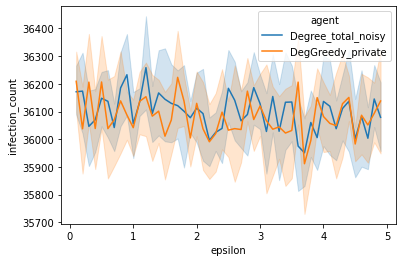

In [2]:
df_mont = pd.read_csv(PROJECT_ROOT / "output" / "run_gXTrP" / "results.csv")
sns.lineplot(data = df_mont, x = 'epsilon', y = 'infection_count', hue = 'agent')

In [9]:
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_FSL2A" / "results.csv")
print(df_digital_part1["agent"])
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Noisy Degree"]

0            Degree_V2_noisy
1            Degree_V2_noisy
2            Degree_V2_noisy
3            Degree_V2_noisy
4            Degree_V2_noisy
                ...         
1735    DegGreedy_private_V2
1736    DegGreedy_private_V2
1737    DegGreedy_private_V2
1738    DegGreedy_private_V2
1739    DegGreedy_private_V2
Name: agent, Length: 1740, dtype: object


In [7]:
df_digital_part1.head()

,G,budget,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,snitch_rate,from_cache,agent,trial_id,infection_count,infections_step


### Comparison of Methods ###

##### New Version #####

In [20]:
df_mont = pd.read_csv(PROJECT_ROOT / "output" / "run_XK2Wx" / "results.csv")
df_mont = pd.concat([df_mont, pd.read_csv(PROJECT_ROOT / "output" / "run_YSarn" / "results.csv")])
df_mont = pd.concat([df_mont, pd.read_csv(PROJECT_ROOT / "output" / "run_gKts5" / "results.csv")])    #Full baselines
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_H4uxJ" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_PzsWx" / "results.csv")
df_mont = pd.concat([df_mont, df_digital_part1, df_digital_part2])    #Digital

df_cville = pd.read_csv(PROJECT_ROOT / "output" / "run_HHUqV" / "results.csv")
df_cville = pd.concat([df_cville, pd.read_csv(PROJECT_ROOT / "output" / "run_nRBkk" / "results.csv")])
df_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_KGnVy" / "results.csv")
df_part1 = df_part1[df_part1["budget"]<= 1500]                                                         #Full baselines (part 1)
df_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_Hvk8W" / "results.csv")                          #Full baselines (part 2)
df_cville = pd.concat([df_cville, df_part1, df_part2])
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_3egJD" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_NVHEx" / "results.csv")
df_cville = pd.concat([df_cville, df_digital_part1, df_digital_part2])
#df_cville = pd.concat([df_cville, pd.read_csv(PROJECT_ROOT / "output" / "run_3egJD" / "results.csv")]) #Digital

df_mont_edges = pd.read_csv(PROJECT_ROOT / "output" / "run_Txksw" / "results.csv")
df_mont_edges = pd.concat([df_mont_edges, pd.read_csv(PROJECT_ROOT / "output" / "run_4AUu7" / "results.csv")])
df_mont_edges = pd.concat([df_mont_edges, pd.read_csv(PROJECT_ROOT / "output" / "run_2gPBD" / "results.csv")])    #Full baselines
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_Xfgpk" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_dTJcu" / "results.csv")
df_mont_edges = pd.concat([df_mont_edges, df_digital_part1, df_digital_part2])    #Digital

df_cville_edges = pd.read_csv(PROJECT_ROOT / "output" / "run_X9z7Y" / "results.csv")
df_cville_edges = pd.concat([df_cville_edges, pd.read_csv(PROJECT_ROOT / "output" / "run_T9eDX" / "results.csv")])
df_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_6TLVb" / "results.csv")                                       #Full baselines
df_part1 = df_part1[df_part1["budget"]<=1700]
df_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_KXypB" / "results.csv")
df_part2 = df_part2[df_part2["budget"]>=1700]
df_cville_edges = pd.concat([df_cville_edges,  df_part1, df_part2]) #Full baseline
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_FSL2A" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_dpLvN" / "results.csv")
df_cville_edges = pd.concat([df_cville_edges, df_digital_part1, df_digital_part2]) #Digital

df_mont_none = pd.read_csv(PROJECT_ROOT / "output" / "run_k3mHM" / "results.csv")
df_cville_none = pd.read_csv(PROJECT_ROOT / "output" / "run_RFUC4" / "results.csv")

df = pd.concat([df_mont, df_mont_none, df_mont_edges, df_cville, df_cville_edges, df_cville_none])
df = df.replace({ 'DegGreedy_fair':'DegGreedy', 'DepRound_fair':'DepRound', 'segmented_greedy': 'SegDegree',
                 'Random':'Random Sol', 'NoIntervention':'None', 'List_Length': 'List Length', 'Degree_I': 'Most Named',
                'Degree': 'Degree V2', 'Degree_V2_noisy': 'Noisy Degree', "DegGreedy_private_V2":"Private DegGreedy"})

df = df.rename(columns={"agent":"Alg for MinExposed"})

df["infection_list"] = df["infections_step"].apply(lambda x: [int(i) for i in x.strip("[]").split(", ")])
df["time_steps"] = df["infection_list"].apply(lambda x: len(x))
df["time_step_peak"] = df["infection_list"].apply(lambda x: x.index(max(x)))
df["peak_count"] = df["infection_list"].apply(lambda x: max(x))

def size(name: str):
    if name[0] == "c": return 131219
    else: return 75457

df["infected"] = df.apply(lambda x: 100.0*x["infection_count"]/size(x["G"]), axis = 1)
df["peak"] = df.apply(lambda x: 100.0*x["peak_count"]/size(x["G"]), axis = 1)

df = pd.concat([df[df["Alg for MinExposed"] == "DegGreedy"], df[df["Alg for MinExposed"] == "DepRound"],
                 df[df["Alg for MinExposed"] == "SegDegree"], df[df["Alg for MinExposed"] == "Random Sol"],
               df[df["Alg for MinExposed"] == "None"], df[df["Alg for MinExposed"] == "Most Named"], df[df["Alg for MinExposed"] == "List Length"], df[df["Alg for MinExposed"] == "Noisy Degree"], df[df["Alg for MinExposed"] == "Private DegGreedy"]])

df_mont_full = df[(df["G"] == "montgomery") & ((df["Alg for MinExposed"] == "Most Named") | (df["Alg for MinExposed"] == "List Length") | (df["Alg for MinExposed"] == "DepRound") | (df["Alg for MinExposed"] == "DegGreedy"))]
df_cville_full = df[(df["G"] == "cville") & ((df["Alg for MinExposed"] == "Most Named") | (df["Alg for MinExposed"] == "List Length")|(df["Alg for MinExposed"] == "DepRound" )| (df["Alg for MinExposed"] == "DegGreedy"))]

df_mont_star_full = df[(df["G"] == "montgomery_extra") & ((df["Alg for MinExposed"] == "Most Named") | (df["Alg for MinExposed"] == "List Length") | (df["Alg for MinExposed"] == "DepRound") | (df["Alg for MinExposed"] == "DegGreedy"))]
df_cville_star_full = df[(df["G"] == "cville_extra") & ((df["Alg for MinExposed"] == "Most Named") | (df["Alg for MinExposed"] == "List Length")|(df["Alg for MinExposed"] == "DepRound" )| (df["Alg for MinExposed"] == "DegGreedy"))]

df_mont_manual = df[(df["G"] == "montgomery") & ((df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]
df_cville_manual = df[(df["G"] == "cville") & ((df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]

df_mont_star_manual = df[(df["G"] == "montgomery_extra") & ((df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]
df_cville_star_manual = df[(df["G"] == "cville_extra") & ((df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]

df_mont_digital = df[(df["G"] == "montgomery") & ((df["Alg for MinExposed"] == "Noisy Degree" )| (df["Alg for MinExposed"] == "Private DegGreedy"))]
df_cville_digital = df[(df["G"] == "cville") & ((df["Alg for MinExposed"] == "Noisy Degree") | (df["Alg for MinExposed"] == "Private DegGreedy"))]

df_mont_star_digital = df[(df["G"] == "montgomery_extra") & ((df["Alg for MinExposed"] == "Noisy Degree" )| (df["Alg for MinExposed"] == "Private DegGreedy"))]
df_cville_star_digital = df[(df["G"] == "cville_extra") & ((df["Alg for MinExposed"] == "Noisy Degree") | (df["Alg for MinExposed"] == "Private DegGreedy"))]

In [4]:
print(set(df["Alg for MinExposed"]))

{'Noisy Degree', 'Most Named', 'Private DegGreedy', 'SegDegree', 'Random Sol', 'DegGreedy', 'List Length', 'DepRound', 'None'}


##### Full Information

###### 2x2 plot? 2 networks and 2 measurements (total, peak)

In [7]:
from collections import namedtuple

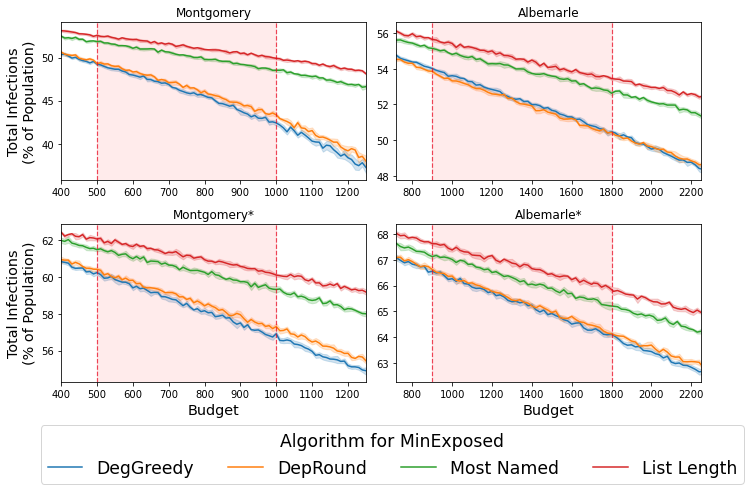

In [67]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_full, (400, 1250), (500, 1000)), data_info("Albemarle", df_cville_full, (720, 2250), (900, 1800)), 
        data_info("Montgomery*", df_mont_star_full,(400, 1250), (500, 1000)), data_info("Albemarle*", df_cville_star_full, (720, 2250), (900, 1800))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2+col].x_lim[0],data[row*2+col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
    
        a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["DegGreedy", "DepRound", "Most Named", "List Length"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')
fig.savefig("../output/plots/budget_sensitivity_full.png", dpi=500, bbox_inches = 'tight')

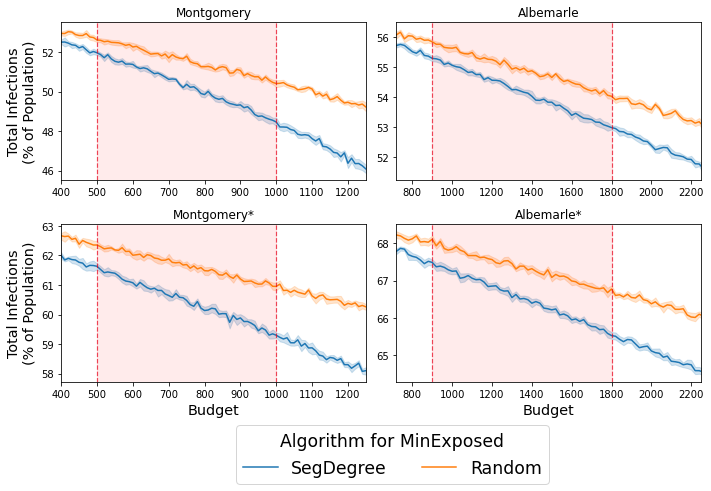

In [11]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_manual,(400, 1250), (500, 1000)), data_info("Albemarle", df_cville_manual, (720, 2250), (900, 1800)), data_info("Montgomery*",df_mont_star_manual,(400, 1250), (500, 1000)), data_info("Albemarle*", df_cville_star_manual, (720, 2250), (900, 1800))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2+col].x_lim[0],data[row*2+col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
        
        a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["SegDegree", "Random"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

fig.savefig("../output/plots/budget_sensitivity_manual.png", dpi=500, bbox_inches = 'tight')

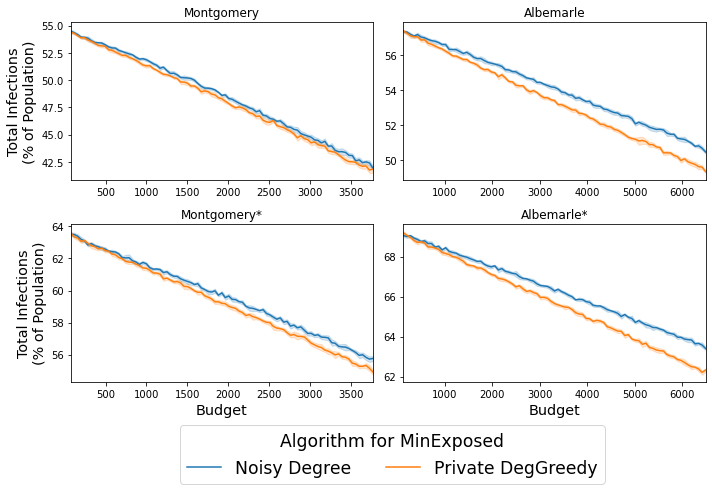

In [21]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_digital,(df_mont_digital['budget'].min(), df_mont_digital['budget'].max()), (df_mont_digital['budget'].min(), df_mont_digital['budget'].max())),
        data_info("Albemarle", df_cville_digital, (df_cville_digital['budget'].min(), df_cville_digital['budget'].max()), (df_cville_digital['budget'].min(), df_cville_digital['budget'].max())),
        data_info("Montgomery*",df_mont_star_digital, (df_mont_star_digital['budget'].min(), df_mont_star_digital['budget'].max()), (df_mont_star_digital['budget'].min(), df_mont_star_digital['budget'].max())),
        data_info("Albemarle*", df_cville_star_digital, (df_cville_star_digital['budget'].min(), df_cville_star_digital['budget'].max()), (df_cville_star_digital['budget'].min(), df_cville_star_digital['budget'].max()))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2 + col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        #a.axvline(x=data[row*2 + col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        #a.axvline(x=data[row*2 + col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        #a.axvspan(data[row*2 + col].x_range[0], data[row*2 + col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2 + col].x_lim[0],data[row*2 + col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
        
        a.set_title(data[row*2+col].title)

fig.tight_layout()

legend = fig.legend(["Noisy Degree", "Private DegGreedy"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

fig.savefig("../output/plots/budget_sensitivity_digital_2.png", dpi=500, bbox_inches = 'tight')

TypeError: tuple indices must be integers or slices, not str

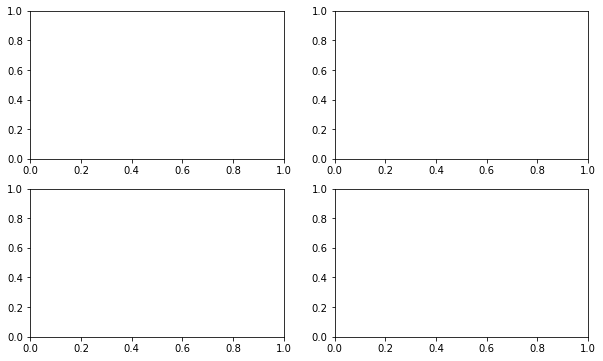

In [8]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_full,(400, 1250), (500, 100)), data_info("Montgomery", df_mont_digital,(400, 1250), (500, 100)),data_info("Montgomery", df_mont_manual,(400, 1250), (500, 1000))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        a.plot(list(data[0]["infection_list"]),data[0]["infection_list"])

fig.tight_layout()

legend = fig.legend(["SegDegree", "Random"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

#fig.savefig("../output/plots/budget_sensitivity_manual.png", dpi=500, bbox_inches = 'tight')

In [ ]:
df = data[0]
plt.plot(list(data[0][]["infection_list"]),data[0]["infection_list"])

### Degree

In [22]:
def Degree_I(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
    for u in state.V1:
        count = sum([1 for v in state.G.neighbors(u) if v in state.SIR.I2])
        degrees.append((count, u))
        
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

def Degree_total(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
    for u in state.V1:
        count = sum([1 for v in state.G.neighbors(u)])
        degrees.append((count, u))
        
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

def List_Length(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
    
    v1_to_score = {}
    for i in state.SIR.I2:
        v1_neighbors = [v for v in state.G.neighbors(i) if v in state.V1]
        
        for v in v1_neighbors:
        
            if v in v1_to_score:
                v1_to_score[v] += 1/len(v1_neighbors)
            else:
                v1_to_score[v] = 1/len(v1_neighbors)
    
    degrees = [(value, key) for key, value in v1_to_score.items()]
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

In [8]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = Degree_total(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
487
564
757
1049
1371
1774
2315
2870
3389
3744
3828
3519
2956
2321
1668
1181
746
475
287
155
61
27
8
2
1
0
36165


In [12]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = Degree(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
481
613
841
1119
1495
2022
2676
3253
3734
4045
3884
3450
2737
2185
1433
992
619
377
207
100
31
17
6
3
1
0
36931


In [14]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = Degree_I(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
470
612
987
1455
2057
2935
3864
4631
4808
4519
3711
2671
1734
1165
711
387
203
120
63
20
4
2
5
1
1
0
37746


In [23]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = List_Length(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
468
683
937
1399
2127
3010
3940
4684
4928
4577
3793
2834
2003
1254
774
430
283
143
74
22
5
2
0
38980


### Digital DegGreedy ###

In [2]:
import random #Default random number generator,
#random.SecureRandom() provides high-quality randomness from /dev/urandom or similar
from fractions import Fraction #we will work with rational numbers

#sample uniformly from range(m)
#all randomness comes from calling this
def sample_uniform(m,rng):
    assert isinstance(m,int) #python 3
    #assert isinstance(m,(int,long)) #python 2
    assert m>0
    return rng.randrange(m)

#sample from a Bernoulli(p) distribution
#assumes p is a rational number in [0,1]
def sample_bernoulli(p,rng):
    assert isinstance(p,Fraction)
    assert 0 <= p <= 1
    m=sample_uniform(p.denominator,rng)
    if m < p.numerator:
        return 1
    else:
        return 0

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number in [0,1]
def sample_bernoulli_exp1(x,rng):
    assert isinstance(x,Fraction)
    assert 0 <= x <= 1
    k=1
    while True:
        if sample_bernoulli(x/k,rng)==1:
            k=k+1
        else:
            break
    return k%2

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number >=0
def sample_bernoulli_exp(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    #Sample floor(x) independent Bernoulli(exp(-1))
    #If all are 1, return Bernoulli(exp(-(x-floor(x))))
    while x>1:
        if sample_bernoulli_exp1(Fraction(1,1),rng)==1:
            x=x-1
        else:
            return 0
    return sample_bernoulli_exp1(x,rng)

#sample from a geometric(1-exp(-x)) distribution
#assumes x is a rational number >= 0
def sample_geometric_exp_slow(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    k=0
    while True:
        if sample_bernoulli_exp(x,rng)==1:
            k=k+1
        else:
            return k
            
#sample from a geometric(1-exp(-x)) distribution
#assumes x >= 0 rational
def sample_geometric_exp_fast(x,rng):
    assert isinstance(x,Fraction)
    if x==0: return 0 #degenerate case
    assert x>0

    t=x.denominator
    while True:
        u=sample_uniform(t,rng)
        b=sample_bernoulli_exp(Fraction(u,t),rng)
        if b==1:
            break
    v=sample_geometric_exp_slow(Fraction(1,1),rng)
    value = v*t+u
    return value//x.numerator
    
#sample from a discrete Laplace(scale) distribution
#Returns integer x with Pr[x] = exp(-abs(x)/scale)*(exp(1/scale)-1)/(exp(1/scale)+1)
#casts scale to Fraction
#assumes scale>=0
def sample_dlaplace(scale,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    scale = Fraction(scale)
    assert scale >= 0
    while True:
        sign=sample_bernoulli(Fraction(1,2),rng)
        magnitude=sample_geometric_exp_fast(1/scale,rng)
        if sign==1 and magnitude==0: continue
        return magnitude*(1-2*sign)

In [29]:
import random #Default random number generator,
#random.SecureRandom() provides high-quality randomness from /dev/urandom or similar
from fractions import Fraction #we will work with rational numbers

#sample uniformly from range(m)
#all randomness comes from calling this
def sample_uniform(m,rng):
    assert isinstance(m,int) #python 3
    #assert isinstance(m,(int,long)) #python 2
    assert m>0
    return rng.randrange(m)

#sample from a Bernoulli(p) distribution
#assumes p is a rational number in [0,1]
def sample_bernoulli(p,rng):
    assert isinstance(p,Fraction)
    assert 0 <= p <= 1
    m=sample_uniform(p.denominator,rng)
    if m < p.numerator:
        return 1
    else:
        return 0

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number in [0,1]
def sample_bernoulli_exp1(x,rng):
    assert isinstance(x,Fraction)
    assert 0 <= x <= 1
    k=1
    while True:
        if sample_bernoulli(x/k,rng)==1:
            k=k+1
        else:
            break
    return k%2

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number >=0
def sample_bernoulli_exp(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    #Sample floor(x) independent Bernoulli(exp(-1))
    #If all are 1, return Bernoulli(exp(-(x-floor(x))))
    while x>1:
        if sample_bernoulli_exp1(Fraction(1,1),rng)==1:
            x=x-1
        else:
            return 0
    return sample_bernoulli_exp1(x,rng)

#sample from a geometric(1-exp(-x)) distribution
#assumes x is a rational number >= 0
def sample_geometric_exp_slow(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    k=0
    while True:
        if sample_bernoulli_exp(x,rng)==1:
            k=k+1
        else:
            return k
            
#sample from a geometric(1-exp(-x)) distribution
#assumes x >= 0 rational
def sample_geometric_exp_fast(x,rng):
    assert isinstance(x,Fraction)
    if x==0: return 0 #degenerate case
    assert x>0

    t=x.denominator
    while True:
        u=sample_uniform(t,rng)
        b=sample_bernoulli_exp(Fraction(u,t),rng)
        if b==1:
            break
    v=sample_geometric_exp_slow(Fraction(1,1),rng)
    value = v*t+u
    return value//x.numerator
    
#sample from a discrete Laplace(scale) distribution
#Returns integer x with Pr[x] = exp(-abs(x)/scale)*(exp(1/scale)-1)/(exp(1/scale)+1)
#casts scale to Fraction
#assumes scale>=0
def sample_dlaplace(scale,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    scale = Fraction(scale)
    assert scale >= 0
    while True:
        sign=sample_bernoulli(Fraction(1,2),rng)
        magnitude=sample_geometric_exp_fast(1/scale,rng)
        if sign==1 and magnitude==0: continue
        return magnitude*(1-2*sign)
        
#compute floor(sqrt(x)) exactly
#only requires comparisons between x and integer
def floorsqrt(x):
    assert x >= 0
    #a,b integers
    a=0 #maintain a^2<=x
    b=1 #maintain b^2>x
    while b*b <= x:
        b=2*b #double to get upper bound
    #now do binary search
    while a+1<b:
        c=(a+b)//2 #c=floor((a+b)/2)
        if c*c <= x:
            a=c
        else:
            b=c
    #check nothing funky happened
    #assert isinstance(a,int) #python 3
    #assert isinstance(a,(int,long)) #python 2
    return a
    
#sample from a discrete Gaussian distribution N_Z(0,sigma2)
#Returns integer x with Pr[x] = exp(-x^2/(2*sigma2))/normalizing_constant(sigma2)
#mean 0 variance ~= sigma2 for large sigma2
#casts sigma2 to Fraction
#assumes sigma2>=0
def sample_dgauss(sigma2,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    sigma2=Fraction(sigma2)
    if sigma2==0: return 0 #degenerate case
    assert sigma2 > 0
    t = floorsqrt(sigma2)+1
    while True:
        candidate = sample_dlaplace(t,rng=rng)
        bias=((abs(candidate)-sigma2/t)**2)/(2*sigma2)
        if sample_bernoulli_exp(bias,rng)==1:
            return candidate
        
#########################################################################
#DONE That's it! Now some utilities

import math #need this, code below is no longer exact

#Compute the normalizing constant of the discrete gaussian
#i.e. sum_{x in Z} exp(-x^2/2sigma2)
#By Poisson summation formula, this is equivalent to
# sqrt{2*pi*sigma2}*sum_{y in Z} exp(-2*pi^2*sigma2*y^2)
#For small sigma2 the former converges faster
#For large sigma2, the latter converges faster
#crossover at sigma2=1/2*pi
#For intermediate sigma2, this code will compute both and check
def normalizing_constant(sigma2):
    original=None
    poisson=None
    if sigma2<=1:
        original = 0
        x=1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0:
            original = original + math.exp(-x*x/(2.0*sigma2))
            x = x - 1 #sum from small to large for improved accuracy
        original = 2*original + 1 #symmetrize and add x=0
    if sigma2*100 >= 1:
        poisson = 0
        y = 1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0:
            poisson = poisson + math.exp(-math.pi*math.pi*sigma2*2*y*y)
            y = y - 1 #sum from small to large
        poisson = math.sqrt(2*math.pi*sigma2)*(1+2*poisson)
    if poisson is None: return original
    if original is None: return poisson
    #if we have computed both, check equality
    scale = max(1,math.sqrt(2*math.pi*sigma2)) #tight-ish lower bound on constant
    assert -1e-15*scale <= original-poisson <= 1e-15*scale
    #10^-15 is about as much precision as we can expect from double precision floating point numbers
    #64-bit float has 56-bit mantissa 10^-15 ~= 2^-50
    return (original+poisson)/2

#compute the variance of discrete gaussian
#mean is zero, thus:
#var = sum_{x in Z} x^2*exp(-x^2/(2*sigma2)) / normalizing_constant(sigma2)
#By Poisson summation formula, we have equivalent expression:
# variance(sigma2) = sigma2 * (1 - 4*pi^2*sigma2*variance(1/(4*pi^2*sigma2)) )
#See lemma 20 https://arxiv.org/pdf/2004.00010v3.pdf#page=17
#alternative expression converges faster when sigma2 is large
#crossover point (in terms of convergence) is sigma2=1/(2*pi)
#for intermediate values of sigma2, we compute both expressions and check
def variance(sigma2):
    original=None
    poisson=None
    if sigma2<=1: #compute primary expression
        original=0
        x = 1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0: #sum from small to large for improved accuracy
            original = original + x*x*math.exp(-x*x/(2.0*sigma2))
            x=x-1
        original = 2*original/normalizing_constant(sigma2)
    if sigma2*100>=1:
        poisson=0 #we will compute sum_{y in Z} y^2 * exp(-2*pi^2*sigma2*y^2)
        y=1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0: #sum from small to large
            poisson = poisson + y*y*math.exp(-y*y*2*sigma2*math.pi*math.pi)
            y=y-1
        poisson = 2*poisson/normalizing_constant(1/(4*sigma2*math.pi*math.pi))
        #next convert from variance(1/(4*pi^2*sigma2)) to variance(sigma2)
        poisson = sigma2*(1-4*sigma2*poisson*math.pi*math.pi)
    if original is None: return poisson
    if poisson is None: return original
    #if we have computed both check equality
    assert -1e-15*sigma2 <= original-poisson <= 1e-15*sigma2
    return (original+poisson)/2

(array([ 1.,  1.,  2.,  3., 10., 24., 40., 13.,  3.,  3.]),
 array([-12. , -10.1,  -8.2,  -6.3,  -4.4,  -2.5,  -0.6,   1.3,   3.2,
          5.1,   7. ]),
 <BarContainer object of 10 artists>)

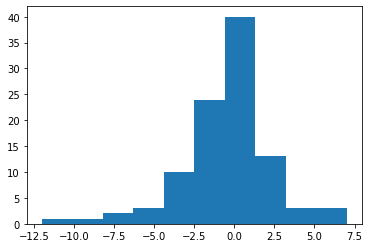

In [60]:
import matplotlib.pyplot as plt
plt.hist([sample_dlaplace(1/(1/2)) for i in range(100)])

In [21]:
epsilon = 2
import networkx as nx

def DegGreedy_private(state: InfectionState):
    
    weights: List[Tuple[int, int]] = []
    
    noises = []
    
    for u in state.V1:
        noise = sample_dgauss(1/(epsilon))
        noises.append(noise)
        deg_noise = len(set(state.G.neighbors(u))) + noise
        #deg_noise = len(set(state.G.neighbors(u)))
        w_sum = state.transmission_rate * max(1, deg_noise)
        
        #infected_nbr_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        #probability_infected = 1 - math.pow(1-state.transmission_rate, 
        #                                    max(1, infected_nbr_count + sample_dgauss(1/(epsilon))))
        
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                                        max(1, deg_noise//10))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    #plt.hist(noises)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_total_noisy(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
        
    noises = []
    
    for u in state.V1:
        noise = sample_dgauss(1/epsilon)
        noises.append(noise)
        count = max(1, len(set(state.G.neighbors(u))) + noise)
        degrees.append((count, u))
    
    plt.hist(noises)
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

In [26]:
epsilon = 1
import networkx as nx

def DegGreedy_private_V2(state: InfectionState):
    
    weights: List[Tuple[int, int]] = []
    
    noises = []
    
    for u in state.V1:
        noise = sample_dlaplace(sqrt(2)/(epsilon/2))
        noises.append(noise)
        #deg_noise = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0]) + noise
        
        deg_I = 0
        deg_V2 = 0
        for i in set(state.G.neighbors(u)):
            if i in state.SIR.I2:
                deg_I += 1
            elif i in state.V2:
                deg_V2 += 1
        
        deg_noise_V2 = deg_V2 + noise
        deg_noise_I = deg_I + sample_dlaplace(sqrt(2)/(epsilon/2))
        
        w_sum = state.transmission_rate * max(1, deg_noise_V2)
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, deg_noise_I))
        
        #deg_noise_V2 = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0]) + noise
        #deg_noise = len(set(state.G.neighbors(u)))
        
        '''w_sum = state.transmission_rate * max(1, deg_noise_V2)
        
        infected_nbr_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, infected_nbr_count + sample_dgauss(1/(epsilon/2))))'''
        
        #probability_infected = 1 - math.pow(1-state.transmission_rate, 
        #                                                max(1, deg_noise))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    #plt.hist(noises)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_V2_noisy(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
        
    noises = []
    
    for u in state.V1:
        noise = sample_dgauss(1/epsilon)
        noises.append(noise)
        count = max(1, sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i] != 0]) + noise)
        degrees.append((count, u))
    
    plt.hist(noises)
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

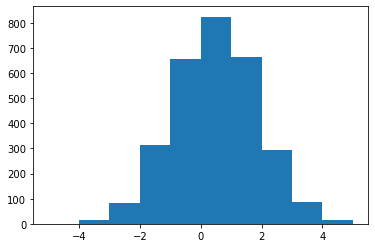

In [62]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

q = DegGreedy_private(state)

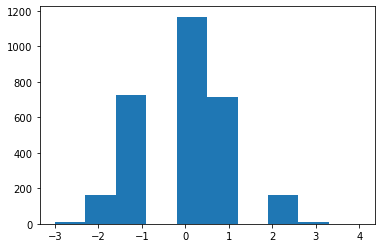

In [63]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

q = Degree_total_noisy(state)

269
459
605
779
993
1277
1719
2151
2722
3370
3800
3973
3689
3164
2484
1833
1258
853
507
313
182
93
31
6
5
2
0
36878


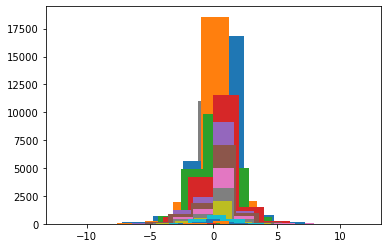

In [5]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = Degree_V2_noisy(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

In [32]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = DegGreedy_private_V2(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
476
620
777
1098
1528
2082
2663
3394
3865
4129
4006
3513
2755
2100
1449
975
627
361
205
97
35
10
4
0
37379


In [8]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

total_time = []
while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    start = time.time()
    q = DegGreedy_private_V2(state)
    end = time.time()
    total_time.append(end-start)
    print(end-start)
    
    state.step(q)
    #print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))
print(sum(total_time)/len(total_time), max(total_time))

0.6339502334594727
0.6737461090087891
1.0322508811950684
1.4249041080474854
2.054828643798828
2.7282497882843018
3.9464690685272217
5.383444786071777
6.7187721729278564


KeyboardInterrupt: 

In [38]:
epsilon = 1
import networkx as nx

def DegGreedy_private_V2(state: InfectionState):
    
    weights: List[Tuple[int, int]] = []
    
    for u in state.V1:
        noise = sample_dlaplace(1/(math.sqrt(2)*epsilon/2))
        #deg_noise = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0]) + noise
        
        deg_noise_V2 = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0]) + noise
        #deg_noise_V2 = len(set(state.G.neighbors(u)))
        
        w_sum = state.transmission_rate * max(1, deg_noise_V2)
        
        infected_nbr_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, infected_nbr_count + sample_dlaplace(1/(math.sqrt(2) * epsilon/2))))
        
        #probability_infected = 1 - math.pow(1-state.transmission_rate, 
        #                                                max(1, deg_noise))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    #plt.hist(noises)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_V2_noisy(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
        
    noises = []
    
    for u in state.V1:
        noise = sample_dlaplace(1/epsilon)
        noises.append(noise)
        #count = max(1, sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i] != 0]) + noise)
        count = max(1, len(set(state.G.neighbors(u))) + noise)
        degrees.append((count, u))
    
    plt.hist(noises)
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

In [29]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

total_time = []
while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    start = time.time()
    q = DegGreedy_private_V2_2(state)
    end = time.time()
    total_time.append(end-start)
    print(end-start)
    
    state.step(q)
    #print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))
print(sum(total_time)/len(total_time), max(total_time))

1.1512188911437988
1.2350220680236816
1.9543204307556152
2.782266139984131
3.609487295150757
5.205968141555786
7.016993284225464
8.990979433059692
10.773638248443604
12.237364053726196
12.899539232254028
12.600274562835693
10.759570360183716
8.654887199401855
6.5129218101501465
4.493140935897827
2.92966365814209
1.7677884101867676
1.0107145309448242
0.5481741428375244
0.1904456615447998
0.062058448791503906
0.013244152069091797
0.002385854721069336
1.6927719116210938e-05
36424
4.696083354949951 12.899539232254028


In [55]:
epsilon = 1
import networkx as nx

def DegGreedy_private_V2(state: InfectionState):
    
    weights: List[Tuple[int, int]] = []
    
    for u in state.V1:
        deg_noise_V2 = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0])
        infected_nbr_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        
        deg_noise_V2 += sample_dlaplace(1/(math.sqrt(2)*epsilon/2))
        infected_nbr_count += sample_dlaplace(1/(math.sqrt(2)*epsilon/2))
        
        w_sum = state.transmission_rate * max(1, deg_noise_V2)
        
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, infected_nbr_count))
        
        #probability_infected = 1 - math.pow(1-state.transmission_rate, 
        #                                                max(1, deg_noise))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    #plt.hist(noises)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_V2_noisy(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
        
    noises = []
    
    for u in state.V1:
        noise = sample_dlaplace(1/(epsilon))
        noises.append(noise)
        #count = max(1, sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i] != 0]) + noise)
        count = max(1, len(set(state.G.neighbors(u))) + noise)
        degrees.append((count, u))
    
    plt.hist(noises)
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

36198
36123
36137
35688
35980
[36198, 36123, 36137, 35688, 35980]
36025.2


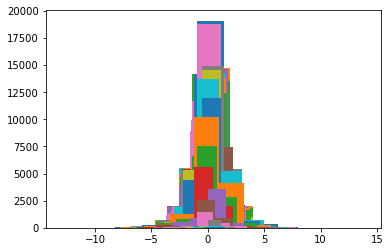

In [45]:
totals = []
for i in range(5):
    G = load_graph_montgomery_labels()
    with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
            j = json.load(infile)

            (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
            infections = j["infections"]

    state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

    while len(state.SIR.I1) + len(state.SIR.I2) != 0:
        q = Degree_V2_noisy(state)
        state.step(q)
        #print(len(state.SIR.I2))
    
    print(len(state.SIR.R))
    totals.append(len(state.SIR.R))

print(totals)
print(sum(totals)/len(totals))

In [56]:
totals = []
for i in range(5):
    G = load_graph_montgomery_labels()
    with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
            j = json.load(infile)

            (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
            infections = j["infections"]

    state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

    while len(state.SIR.I1) + len(state.SIR.I2) != 0:
        q = DegGreedy_private_V2(state)
        state.step(q)
        #print(len(state.SIR.I2))
    
    print(len(state.SIR.R))
    totals.append(len(state.SIR.R))

print(totals)
print(sum(totals)/len(totals))

37166
37229
37163
37271
37271
[37166, 37229, 37163, 37271, 37271]
37220.0


In [26]:
epsilon = 0.1

def find_excluded_contours_edges_PQ3(G: nx.Graph, infected: Set[int], excluded: Set[int],
                                     transmission_rate: float, snitch_rate:float = 1, 
                                     transmission_known: bool = True):
    P = {}
    v1_k = set()
    exclusion = (set(infected) | set(excluded))
    for v in infected:
        for nbr in effective_neighbor(G, v, G.neighbors(v)):
            if nbr not in exclusion and (random.uniform(0,1) < snitch_rate):
                v1_k.add(nbr)
                if transmission_known:
                    if nbr in P:
                        P[nbr] *= 1-G[v][nbr]["transmission"]
                    else:
                        P[nbr] = 1-G[v][nbr]["transmission"]
                else:
                    if nbr in P:
                        P[nbr] += 1
                    else:
                        P[nbr] = 1
                    
    for key,value in P.items():
        if not transmission_known:
            noise =  sample_dlaplace(1/(epsilon/2))
            #dlaplace.rvs(1/(epsilon/2))
            value_noise = value + noise
            #print(noise, value, value_noise)
            P[key] = math.pow(1-transmission_rate, max(1, value_noise))
        P[key] = 1-P[key]
    
    v2_k = set()
    Q = {}
    exclusion = (set(infected) | set(excluded) | set(v1_k) )
    for u in v1_k:
        for v in set(G.neighbors(u))-exclusion:
            if check_edge_transmission(G, u, v) and (random.uniform(0,1) < snitch_rate):
                if transmission_known:
                    if u in Q:
                        Q[u][v] = G[u][v]["transmission"]
                    else:
                        Q[u] = {v: G[u][v]["transmission"]}
                else:
                    if u in Q:
                        Q[u][v] = transmission_rate
                    else:
                        Q[u] = {v: transmission_rate}
                v2_k.add(v)
            else:
                if u in Q:
                    Q[u][v] = 0
                else:
                    Q[u] = {v:0}
    return v1_k, v2_k, P, Q

def DegGreedy_private(state: InfectionState):
    V1, V2, P, Q = find_excluded_contours_edges_PQ3(state.G, state.SIR.I2, state.SIR.R, 0.05, 1, False)
    
    weights: List[Tuple[int, int]] = []
    
    for u in V1:
        deg = len(set(state.G.neighbors(u))&V2)
        deg_noise = deg + sample_dlaplace(1/(epsilon/2))
        #dlaplace.rvs(1/(epsilon/2))
        #print(deg, deg_noise)
        w_sum = state.transmission_rate * max(0, deg_noise)
        
        u_i_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        u_i_count += sample_dlaplace(1/(epsilon/2))
        
        weights.append(( math.pow(1-transmission_rate, max(1, value_noise)) * (w_sum), u))

    weights.sort(reverse=True)

    return {i[1] for i in weights[:state.budget]}


G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = DegGreedy_private(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

KeyboardInterrupt: 

### Without Privacy ###

In [45]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = Degree_total(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
443
535
685
984
1365
1809
2368
2877
3512
3738
3871
3467
3032
2321
1732
1231
763
450
283
151
61
26
9
1
0
36324


In [46]:
G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "mont.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 750, "none", 0.05, False, -1, False, 1)

while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    q = DegGreedy_fair(state)
    state.step(q)
    print(len(state.SIR.I2))

#q = DegGreedy_private(state)

print(len(state.SIR.R))

269
487
595
746
1040
1373
1719
2195
2664
3188
3602
3678
3488
3032
2357
1692
1117
782
439
275
146
54
33
14
5
0
35331
